In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import sys
import os
sys.path.append(os.path.abspath('..'))

from src.new_or_used import build_dataset
from src.utils import get_ordered_columns, extract_id_from_string_list, tune_model
from preprocessing import preprocess


import time

# Modelos
from sklearn import ensemble, linear_model, neighbors, svm, tree, discriminant_analysis, neural_network
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.preprocessing import MinMaxScaler





# Análisis Exploratorio de Datos (EDA)

En esta notebook se realiza un análisis exploratorio del dataset provisto con el objetivo de entender su estructura, calidad, y las principales variables que pueden influir en la predicción del estado de los productos (nuevo o usado). El análisis incluye:

- Inspección de variables clave y su distribución
- Identificación de valores faltantes y datos inconsistentes
- Análisis de correlaciones y relaciones entre variables
- Revisión de campos anidados o estructurados (listas, diccionarios)
- Extracción de primeras hipótesis y features potencialmente útiles

Este EDA servirá como base para la etapa de modelado y selección de features.


## Preprocesado de datos

- Se desglosa la data proveniente en una lista de diccionarios en un dataframe con el que se trabajara.

In [2]:
data = [json.loads(x) for x in open("../data/MLA_100k_checked_v3.jsonlines")]

In [3]:

# Convertir a DataFrame aplanado
df = pd.json_normalize(data)

# Ordenar columnas
ordered_cols = get_ordered_columns(data)
df = df[[col for col in ordered_cols if col in df.columns]]

# Opcional: reemplazar puntos por guiones bajos
df.columns = [col.replace('.', '_') for col in df.columns]


# Cambio a str el valro de descriptions ya que viene en lista de str
df['descriptions'] = df['descriptions'].apply(extract_id_from_string_list)

In [4]:
df.columns

Index(['seller_address_country_name', 'seller_address_country_id',
       'seller_address_state_name', 'seller_address_state_id',
       'seller_address_city_name', 'seller_address_city_id', 'warranty',
       'sub_status', 'condition', 'deal_ids', 'base_price',
       'shipping_local_pick_up', 'shipping_methods', 'shipping_tags',
       'shipping_free_shipping', 'shipping_mode', 'shipping_dimensions',
       'non_mercado_pago_payment_methods', 'seller_id', 'variations',
       'site_id', 'listing_type_id', 'price', 'attributes', 'buying_mode',
       'tags', 'listing_source', 'parent_item_id', 'coverage_areas',
       'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id', 'official_store_id',
       'differential_pricing', 'accepts_mercadopago', 'original_price',
       'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created',
       'secure_thumbnail', 'stop_time', 'status', 'video_id',
       'catalog_product_id', 'subti

## Analisis de los  atributos 

In [5]:
df.head()

,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,warranty,sub_status,condition,deal_ids,...,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity
0,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,None,[],new,[],...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1
1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,NUESTRA REPUTACION,[],used,[],...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1
2,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,None,[],used,[],...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1
3,Argentina,AR,Capital Federal,AR-C,Floresta,TUxBQkZMTzg5MjFa,None,[],new,[],...,1449191596000,active,None,NaN,None,1,1443466076000,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1
4,Argentina,AR,Buenos Aires,AR-B,Tres de febrero,TUxBQ1RSRTMxODE5NA,MI REPUTACION.,[],used,[],...,1445638040000,active,None,NaN,None,1,1440454040000,http://articulo.mercadolibre.com.ar/MLA7787961...,0,1


#### Analizamos la columna condition que es el target

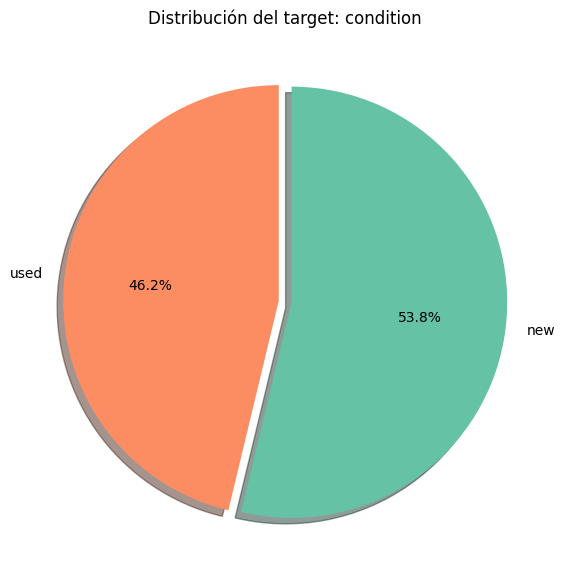

In [6]:


col = 'condition'
counts = df[col].value_counts()

# Colores personalizados (puede ser lista de hex, nombres, etc.)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  # ejemplo: tonos suaves

# Explode: separa un poco cada porción
explode = [0.03] * len(counts)  # separa todos igual

# Graficar
plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=colors[:len(counts)],
    explode=explode,
    shadow=True
)
plt.title(f'Distribución del target: {col}')
plt.ylabel('')  # Oculta etiqueta del eje Y
plt.show()


El target esta bien balanceado por lo que no seran necesario trabajo en este aspecto


#### Analizamos el resto de columnas

In [7]:
# Observo cantidad de nulos y tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   seller_address_country_name       100000 non-null  object 
 1   seller_address_country_id         100000 non-null  object 
 2   seller_address_state_name         100000 non-null  object 
 3   seller_address_state_id           100000 non-null  object 
 4   seller_address_city_name          100000 non-null  object 
 5   seller_address_city_id            100000 non-null  object 
 6   warranty                          39104 non-null   object 
 7   sub_status                        100000 non-null  object 
 8   condition                         100000 non-null  object 
 9   deal_ids                          100000 non-null  object 
 10  base_price                        100000 non-null  float64
 11  shipping_local_pick_up            100000 non-null  bo

In [8]:
# Evaluo que contienen las columnas que tiene como valor listas 
for col_name in df.columns:
    if df[col_name].apply(lambda x: isinstance(x, list)).any():
        has_non_empty_lists = df[col_name].apply(lambda x: isinstance(x, list) and len(x) > 0).any()
        print(f"¿Hay listas NO vacías en '{col_name}'?: {has_non_empty_lists}")
    else:
        pass


¿Hay listas NO vacías en 'sub_status'?: True
¿Hay listas NO vacías en 'deal_ids'?: True
¿Hay listas NO vacías en 'shipping_methods'?: False
¿Hay listas NO vacías en 'shipping_tags'?: True
¿Hay listas NO vacías en 'non_mercado_pago_payment_methods'?: True
¿Hay listas NO vacías en 'variations'?: True
¿Hay listas NO vacías en 'attributes'?: True
¿Hay listas NO vacías en 'tags'?: True
¿Hay listas NO vacías en 'coverage_areas'?: False
¿Hay listas NO vacías en 'pictures'?: True


In [9]:
print(df[df['variations'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['variations'][6])
print(df[df['attributes'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['attributes'][8])

[{'attribute_combinations': [{'value_id': '92012', 'name': 'Color Primario', 'value_name': 'Azul petróleo', 'id': '83000'}, {'value_id': '82034', 'name': 'Color Secundario', 'value_name': 'Amarillo', 'id': '73001'}, {'value_id': '141996', 'name': 'Talle', 'value_name': '8', 'id': '103000'}], 'seller_custom_field': None, 'picture_ids': ['472901-MLA20442937232_102015', '509801-MLA20442939057_102015', '650901-MLA20442940047_102015', '373901-MLA20442951026_102015', '422901-MLA20442950410_102015'], 'sold_quantity': 0, 'available_quantity': 1, 'id': 9742952789, 'price': 180}]
[{'value_id': '', 'attribute_group_id': 'DFLT', 'name': 'Número de pieza', 'value_name': '37123', 'attribute_group_name': 'Otros', 'id': 'PART_NUMBER'}]


In [10]:
# Evaluo la distribucion de cada variable
df['warranty'].value_counts()

warranty
Sí                                                                                                                                                                5682
Sin garantía                                                                                                                                                      5442
SI                                                                                                                                                                 592
6 meses                                                                                                                                                            547
6 MESES                                                                                                                                                            397
                                                                                                                                                            

### Estudiando atributo por atributo se observa:


- "sub_status" tiene > 80% de listas vacias como valor

- "condition", que es el target, esta balanceado

- "deal_ids" tiene > 80% de listas vacias como valor

- "shipping_methods" contiene todas las entradas con listas vacias o Nan

- "shipping_tags" tiene > 80% de listas vacias como valor

- "shipping_free_shipping" tiene > 95% valor False 

- "non_mercado_pago_payment_methods" contiene como valor listas de diccionarios, en este caso se podria realizar feature de cuantos metodos hay que no sean mp

- "variations" contiene como valor listas de diccionarios. Por lo pronto se podria descartar en un primera iteracion debido a que a priori no contiene informacion "relevante"

- "attributes" contiene como valor listas de diccionarios. Por lo pronto se podria descartar en un primera iteracion debido a que a priori no contiene informacion "relevante"

- "coverage_areas" contiene todas listas vacias como valor

- "listing_source" contiene todas string vacias como valor

- "international_delivery_mode" contiene "none" en todas las entradas

- "pictures" contiene como valor listas de diccionarios, en este caso se podria realizar feature de cuantas pictures hay

- "id" y "descriptions" parecen ser lo mismo pero con mas detalle. El primer valor de description es el id, este es seguido por otro codigo

- "status" tiene > 95% de valor de entrada "active"

- "warranty" contiene ~40% de valores NO nulos. No estan normalizados los valores, se puede hacer un binario de si tiene o no garantia

- "shipping_dimensions"  contiene < 10% de valores NO nulos

- "official_store_id"    contiene < 10% de valores NO nulos

- "differential_pricing" contiene < 10% de valores NO nulos

- "original_price"       contiene < 10% de valores NO nulos

- "video_id"             contiene < 10% de valores NO nulos

- "catalog_product_id"   contiene < 10% de valores NO nulos

- "subtitle"             contiene < 10% de valores NO nulos

#### Estudiamos la correlacion que tengan a priori las demas columnas con el target

In [11]:

df_matriz = df.copy()

# target a binario
df_matriz['condition'] = df_matriz['condition'].map({'new': 1, 'used': 0})


# Convertir a int col booleanas
bool_cols = df_matriz.select_dtypes(include='bool').columns
df_matriz[bool_cols] = df_matriz[bool_cols].astype(int)



numeric_df = df_matriz.select_dtypes(include=['number'])


# Conservo solo columnas con al menos 20% de datos no nulos (hasta 80% de nulos)
numeric_df_clean = numeric_df.dropna(thresh=int(0.2 * len(numeric_df)), axis=1)
corr_matrix = numeric_df_clean.corr()


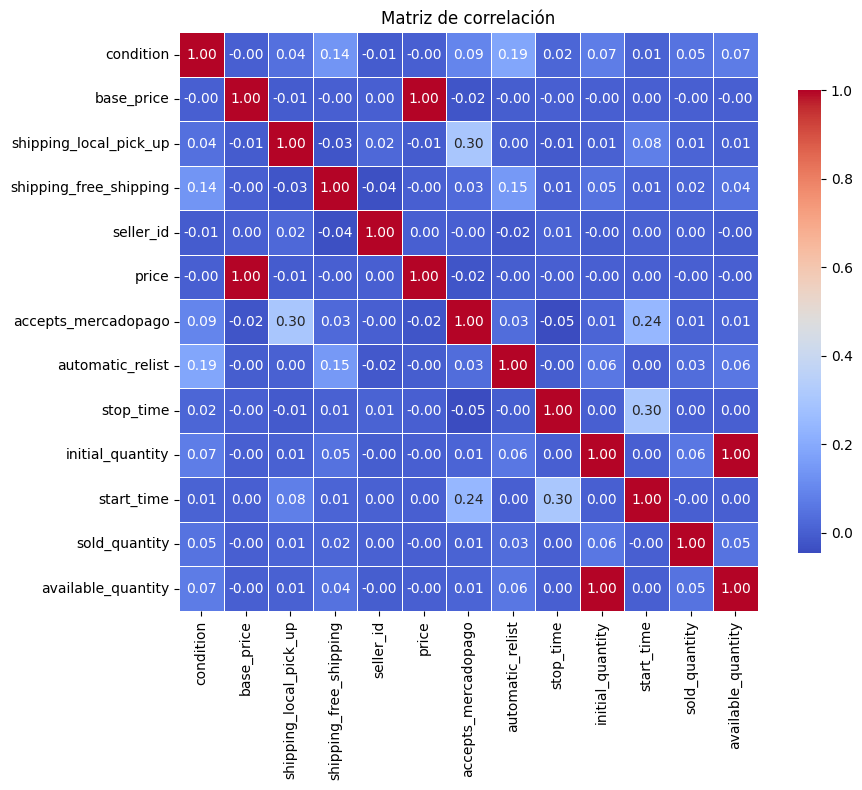

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,         # Muestra los valores
    fmt=".2f",          # Formato con 2 decimales
    cmap="coolwarm",    # Paleta de colores
    square=True,        # Cuadrados proporcionales
    linewidths=0.5,     # Líneas entre celdas
    cbar_kws={"shrink": 0.8}  # Barra lateral más compacta
)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

#### Enlistamos las columnas que mas correlacion tienen con el target. Intuimos estas seran las que mas expliquen la condicion del producto


In [13]:
correlations = numeric_df_clean.corr()['condition'].drop('condition') 
top_corr = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print('Top de correlaciones con el target:')
print(top_corr.head(10).round(2))


Top de correlaciones con el target:
automatic_relist          0.19
shipping_free_shipping    0.14
accepts_mercadopago       0.09
initial_quantity          0.07
available_quantity        0.07
sold_quantity             0.05
shipping_local_pick_up    0.04
stop_time                 0.02
start_time                0.01
seller_id                -0.01
Name: condition, dtype: float64


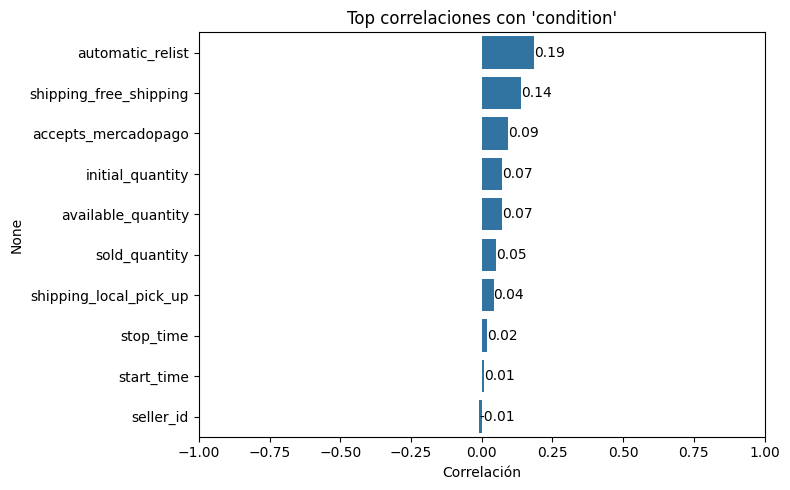

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

top_corr_10 = top_corr.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_corr_10.values, y=top_corr_10.index)
plt.title("Top correlaciones con 'condition'")
plt.xlabel("Correlación")
plt.xlim(-1, 1)

for i, v in enumerate(top_corr_10.values):
    plt.text(v, i, f"{v:.2f}", color='black', va='center')

plt.tight_layout()
plt.show()


#### Observamos la cantidad de valores unicos que contienen las columnas categoricas

In [15]:
import numpy as np

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    try:
        if df[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
            print(f"Columna '{col}' contiene listas o arrays, se omite.")
            continue
        unique_values = df[col].nunique()
        print(f"Columna '{col}' tiene {unique_values} valores únicos.")
    except Exception as e:
        print(f"Error en columna '{col}': {e}")



Columna 'seller_address_country_name' tiene 2 valores únicos.
Columna 'seller_address_country_id' tiene 2 valores únicos.
Columna 'seller_address_state_name' tiene 25 valores únicos.
Columna 'seller_address_state_id' tiene 25 valores únicos.
Columna 'seller_address_city_name' tiene 3656 valores únicos.
Columna 'seller_address_city_id' tiene 295 valores únicos.
Columna 'warranty' tiene 10264 valores únicos.
Columna 'sub_status' contiene listas o arrays, se omite.
Columna 'condition' tiene 2 valores únicos.
Columna 'deal_ids' contiene listas o arrays, se omite.
Columna 'shipping_methods' contiene listas o arrays, se omite.
Columna 'shipping_tags' contiene listas o arrays, se omite.
Columna 'shipping_mode' tiene 4 valores únicos.
Columna 'shipping_dimensions' tiene 13 valores únicos.
Columna 'non_mercado_pago_payment_methods' contiene listas o arrays, se omite.
Columna 'variations' contiene listas o arrays, se omite.
Columna 'site_id' tiene 1 valores únicos.
Columna 'listing_type_id' tien

Se  optara por encodear en valores numericos aquellas columnas categoricas con 30 o menos valores unicos

# Experimentacion de clasificadores

In [31]:
X_train, y_train, X_test, y_test = build_dataset()

In [7]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# convertir target a binario
y_train = list(map({'new': 1, 'used': 0}.get, y_train))
y_test = list(map({'new': 1, 'used': 0}.get, y_test))

# corroboro no haya nulos en los data frames
print('Hay nulos en X_test? ', X_test.isna().sum().any())
print('Hay nulos en X_train? ', X_train.isna().sum().any())

Columnas  codificadas como 'Nombre_Columna_enc'.
Columnas booleanas codificadas: ['shipping_local_pick_up', 'accepts_mercadopago', 'automatic_relist']
Columnas  codificadas como 'Nombre_Columna_enc'.
Columnas booleanas codificadas: ['shipping_local_pick_up', 'accepts_mercadopago', 'automatic_relist']
Hay nulos en X_test?  False
Hay nulos en X_train?  False


In [8]:
# Selecciono columnas numericas
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_cols_test = X_test.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols_test]

In [9]:
#Vemos correlación entre variables numéricas para determihar si hay multicolinealidad y quedarnos con las más relevantes.
df_matriz = X_train_numeric.copy()
corr_matrix = df_matriz.corr()

### Visualización de la matriz de correlación

# plt.figure(figsize=(15, 10))
# sns.heatmap(
#     corr_matrix,
#     annot=True,         # Muestra los valores
#     fmt=".1f",          # Formato con 2 decimales
#     cmap="coolwarm",    # Paleta de colores
#     square=True,        # Cuadrados proporcionales
#     linewidths=0.7,     # Líneas entre celdas
#     cbar_kws={"shrink": 0.8}  # Barra lateral más compacta
# )
# plt.title("Matriz de correlación")
# plt.tight_layout()
# plt.show()

In [10]:
df_matriz = X_train[numeric_cols].copy()
correlations = df_matriz.corr()['condition_enc'].drop('condition_enc') 
top_corr = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print('Top de correlaciones con el target:')
print(top_corr.head(10).round(2))


# Crear nuevo DataFrame solo con columnas con cierto umbral de correlación
# mask = abs(top_corr) > 0.015
mask = top_corr != 0
top_features = top_corr[mask].index.tolist()
X_train_top = X_train_numeric[top_features]
X_test_top = X_test_numeric[top_features]

Top de correlaciones con el target:
automatic_relist_enc       0.19
listing_type_id_enc        0.14
is_free_shipping           0.14
has_warranty               0.13
has_nuevo_in_title         0.12
non_mp_methods_count       0.11
title_word_count           0.10
shipping_mode_enc         -0.10
accepts_mercadopago_enc    0.09
initial_quantity           0.07
Name: condition_enc, dtype: float64


In [ ]:
# Quito columna target antes de entrenar 
X_train_numeric = X_train_numeric.drop(columns=['condition_enc'], errors='ignore')

# verifico que efectivamnete no este target ni en train ni test
print('Hay columna condition en X_train_numeric?', 'condition_enc' in X_train_numeric.columns)
print('Hay columna condition en X_test_numeric?', 'condition_enc' in X_test_numeric.columns)
print('Hay columna condition en X_train_top?', 'condition_enc' in X_train_top.columns)
print('Hay columna condition en X_test_top?', 'condition_enc' in X_test_top.columns)

print('Columnas utilizadas para entrenar:')
print(X_train_top.columns)

Hay columna condition en X_train_numeric? False
Hay columna condition en X_test_numeric? False
Hay columna condition en X_train_top? False
Hay columna condition en X_test_top? False
Columnas utilizadas para entrenar:
Index(['automatic_relist_enc', 'listing_type_id_enc', 'is_free_shipping',
       'has_warranty', 'has_nuevo_in_title', 'non_mp_methods_count',
       'title_word_count', 'shipping_mode_enc', 'accepts_mercadopago_enc',
       'initial_quantity', 'sold_quantity', 'is_active', 'buying_mode_enc',
       'pictures_count', 'shipping_local_pick_up_enc',
       'seller_address_state_id_enc', 'currency_id_enc', 'stop_time',
       'start_time', 'seller_address_state_name_enc', 'seller_id',
       'seller_address_country_name_enc', 'base_price', 'price'],
      dtype='object')


In [ ]:
## Escaleo los datos

scaler = MinMaxScaler()
X_train_top = scaler.fit_transform(X_train_top)
X_test_top = scaler.transform(X_test_top)

In [14]:
# Lista de modelos
MLA = [
    ## Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    ### GLM
    linear_model.LogisticRegressionCV(),
    linear_model.SGDClassifier(),

    ### Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    ### SVM 
    svm.LinearSVC(),

    ### Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    ### Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # ### XGBoost
    XGBClassifier(),

    ### Neural Network
    # neural_network.MLPClassifier(
    #     solver='sgd',
    #     alpha=1e-4,
    #     hidden_layer_sizes=(2),
    #     learning_rate='constant',
    #     learning_rate_init=0.001,
    #     batch_size=20,
    #     random_state=1,
    #     max_iter=100
    # )
]

# Tabla de comparación
MLA_columns = [
    'MLA Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1 Score',
    'Tasa de mala clasificacion',
    'Tiempo'
]
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = pd.DataFrame()
MLA_test = pd.DataFrame()

# Loop de entrenamiento y evaluación
row_index = 0
for alg in MLA:
    inicio = time.time()
    
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name

    alg.fit(X_train_top, y_train)
    y_pred = alg.predict(X_test_top)

    # Métricas
    MLA_compare.loc[row_index, 'Accuracy'] = round(accuracy_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'F1 Score'] = round(f1_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Tasa de mala clasificacion'] = round(1 - accuracy_score(y_test, y_pred), 3)

    fin = time.time()
    MLA_compare.loc[row_index, 'Tiempo'] = round(fin - inicio, 2)

    # Predicciones para análisis
    MLA_predict[MLA_name] = alg.predict(X_train_top)
    MLA_test[MLA_name] = y_pred

    row_index += 1

# Ordenar por precisión
MLA_compare.sort_values(by='Accuracy', ascending=False, inplace=True)




c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [15]:
MLA_compare

,MLA Name,Accuracy,Precision,Recall,F1 Score,Tasa de mala clasificacion,Tiempo
4,RandomForestClassifier,0.874,0.9,0.862,0.88,0.126,12.25
11,XGBClassifier,0.873,0.898,0.863,0.88,0.127,0.39
2,ExtraTreesClassifier,0.87,0.883,0.877,0.88,0.13,7.94
1,BaggingClassifier,0.859,0.894,0.838,0.865,0.141,5.29
3,GradientBoostingClassifier,0.848,0.87,0.844,0.857,0.152,15.83
0,AdaBoostClassifier,0.828,0.827,0.864,0.845,0.172,3.81
9,DecisionTreeClassifier,0.817,0.833,0.826,0.83,0.183,0.9
7,KNeighborsClassifier,0.79,0.806,0.806,0.806,0.21,4.26
10,ExtraTreeClassifier,0.777,0.802,0.78,0.791,0.223,0.1
5,LogisticRegressionCV,0.654,0.706,0.619,0.659,0.346,7.4


### Ajustamos hiperparametros

In [ ]:
param_dist = {
            'n_estimators': [500, 600, 700, 800, 1000],              
            'max_depth': [8, 10, 12, 15],                          
            'learning_rate': [0.05, 0.1, 0.15],                
            'subsample': [0.7, 0.85, 1.0],                     
            'colsample_bytree': [0.7, 0.85, 1.0],              
            'min_child_weight': [1, 5, 10],                    
            'gamma': [0, 1, 5],                                
            'scale_pos_weight': [1]                            
        }

best_xgb = tune_model("xgboost", X_train_top, y_train, param_dist, n_iter=30, cv=5)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Mejor score (xgboost): 0.8802
📌 Mejores parámetros: {'subsample': 0.85, 'scale_pos_weight': 1, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


In [22]:
param_dist = {
    'n_estimators': [200, 500, 700, 800, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

best_rf = tune_model("random_forest", X_train_top, y_train, n_iter=30, cv=5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Mejor score (random_forest): 0.8698
📌 Mejores parámetros: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}


In [24]:
# defino el modelo ganador
best_model = best_xgb  
# Entreno el modelo ganador con todo el conjunto de entrenamiento
best_model.fit(X_train_top, y_train)
# Predicciones finales
y_pred_final = best_model.predict(X_test_top)
# Evaluación final
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"✅ Precisión final del modelo ganador: {final_accuracy:.4f}")


✅ Precisión final del modelo ganador: 0.8841
